In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
import pandas as pd
import sys
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
import ast

In [2]:
#defenition of data path and excel file path
path = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/'
excel = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/ptbxl_database.csv'

In [3]:
#custom class definition
import pandas as pd
import numpy as np
import ast
import wfdb
from torch.utils.data import Dataset
from torchvision import transforms
from scipy.signal import butter, filtfilt

class Custom_class(Dataset):
    def __init__(self, excelfile, path, num_data, transform=None, test_flag=False):
        self.dat = pd.read_csv(excelfile)
        self.col = self.dat['filename_hr'] #only 500 hz files are used for training
        self.data = self.col[:num_data] # specifying the number of data to be loaded for training
        self.label = self.dat['scp_codes'] # used for labelling
        self.labels = self.label[:num_data] 
        self.strat_fold = self.dat['strat_fold']  # Load strat_fold column
        self.path = path 
        self.transform = transform  # Initialize the transform attribute
        self.num_data = num_data
        self.test_flag = test_flag # a flag to set whether we need to load test data or train dat . data which has strat_fold value equal to 10 or 7 is considered as test data and others train data

        if self.test_flag:
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == 10 or self.strat_fold[idx] == 7)]
        else:
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] != 10 and self.strat_fold[idx] != 7)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]  # Adjust index to match filtered data
        y, _ = wfdb.rdsamp(self.path + self.data[idx])  # Use channel 0
        y = y.astype(np.float32)
        y = np.transpose(y)

        # Apply filtering
        y = self.bandpass_filter(y, 1, 47, 500)  # applying BPF

        # Normalize using z-score
        y = self.z_score_normalize(y)
        y = y.astype(np.float32)

        scp_code_dict = ast.literal_eval(self.labels[idx]) #Fetching label from the scp_codes coloumn

        # Check if the first key is 'NORM' and assign the label accordingly
        first_key = max(scp_code_dict, key=scp_code_dict.get) #one key in scp_code dictionary with highest value is considered as label
        label = 0 if first_key == 'NORM' else 1 # if label is NORM then encoded as 1 else 0

        if self.transform:
            y = self.transform(y)

        return y[0, :, :], label

    def bandpass_filter(self, data, lowcut, highcut, fs, order=3):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data, axis=1)
        return y

    def z_score_normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        normalized_data = (data - mean) / std
        return normalized_data

# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
])




# For training data , TOTAL 7000 data is used for TRAINING AND TESTING
train_dataset = Custom_class(excel, path, num_data=7000, transform=transform, test_flag=False)

# For test data
test_dataset = Custom_class(excel, path, num_data=7000, transform=transform, test_flag=True)


In [4]:
print(len(train_dataset))
print(len(test_dataset))

5510
1490


In [5]:
#MODEL DEFINITION
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Res_Block_1
class ResBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the Res_Block_2
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the complete ResNet-50 model with Self-Attention
class ResNet50(nn.Module):
    def __init__(self, input_channels=12, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock1, 64, 128, 1)
        self.layer2 = self._make_layer(ResBlock2, 128, 128, 2)
        self.layer3 = self._make_layer(ResBlock1, 128, 256, 1)
        self.layer4 = self._make_layer(ResBlock2, 256, 256, 3)
        self.layer5 = self._make_layer(ResBlock1, 256, 512, 1)
        self.layer6 = self._make_layer(ResBlock2, 512, 512, 5)
        self.layer7 = self._make_layer(ResBlock1, 512, 1024, 1)
        self.layer8 = self._make_layer(ResBlock2, 1024, 1024, 2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(p=0.5) #added to improve generalization
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def _make_layer(self, block, in_channels, out_channels, blocks):
        layers = []
        layers.append(block(in_channels, out_channels))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = torch.squeeze(x)
        return x

# Instantiate the model and print the summary
model = ResNet50(input_channels=12, num_classes=1)

# Check if CUDA is available and move the model to the GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)

In [7]:
from torch.optim.lr_scheduler import LambdaLR
import math

def lr_lambda(epoch):
    if epoch < 10:
        return 1.0
    else:
        return math.exp(-1)



In [8]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy


criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
# scheduler = LambdaLR(optimizer, lr_lambda)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0




for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = torch.round(outputs)
        # _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Deep copy the model if the current accuracy is the best so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    # scheduler.step()

# Load best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), "best_model.pth")

print(f"Training complete. Best accuracy: {best_acc:.4f}")


Epoch 1/20, Loss: 0.4837, Accuracy: 0.7506
Epoch 2/20, Loss: 0.3697, Accuracy: 0.8479
Epoch 3/20, Loss: 0.3355, Accuracy: 0.8525
Epoch 4/20, Loss: 0.3298, Accuracy: 0.8633
Epoch 5/20, Loss: 0.2986, Accuracy: 0.8775
Epoch 6/20, Loss: 0.2968, Accuracy: 0.8775
Epoch 7/20, Loss: 0.2762, Accuracy: 0.8860
Epoch 8/20, Loss: 0.1967, Accuracy: 0.9279
Epoch 9/20, Loss: 0.1481, Accuracy: 0.9465
Epoch 10/20, Loss: 0.1111, Accuracy: 0.9603
Epoch 11/20, Loss: 0.0924, Accuracy: 0.9681
Epoch 12/20, Loss: 0.0592, Accuracy: 0.9815
Epoch 13/20, Loss: 0.0526, Accuracy: 0.9833
Epoch 14/20, Loss: 0.0494, Accuracy: 0.9831
Epoch 15/20, Loss: 0.0269, Accuracy: 0.9929
Epoch 16/20, Loss: 0.0264, Accuracy: 0.9920
Epoch 17/20, Loss: 0.0231, Accuracy: 0.9940
Epoch 18/20, Loss: 0.0232, Accuracy: 0.9935
Epoch 19/20, Loss: 0.0219, Accuracy: 0.9944
Epoch 20/20, Loss: 0.0200, Accuracy: 0.9951
Training complete. Best accuracy: 0.9951


In [9]:
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), "best_model.pth")

In [10]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=2)

In [11]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

model = ResNet50(input_channels=12, num_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('best_model.pth'))

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            preds = torch.round(outputs)
            preds = preds.int()
            # _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

# Example usage:
# Assuming `model` is your PyTorch model and `test_loader` is your test data loader
accuracy, confusion_matrix = test_model(model, test_dataloader)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)


Accuracy: 0.8214765100671141
Confusion Matrix:
[[588 128]
 [138 636]]


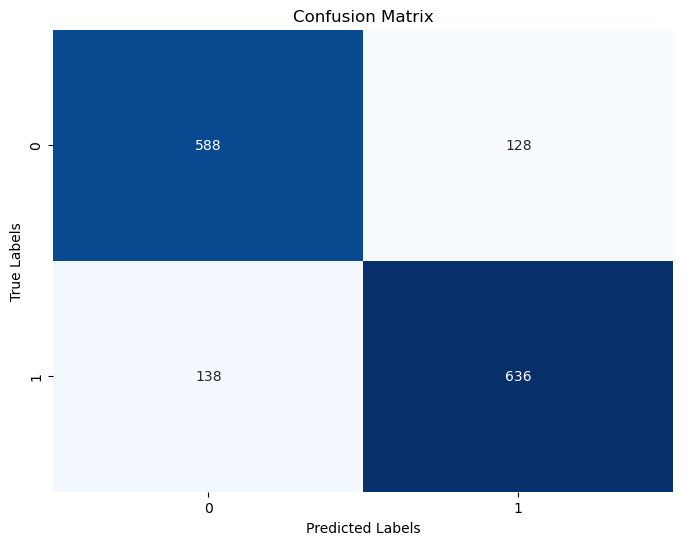

In [12]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()